In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, SVR

import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

In [ ]:
df = pd.read_excel("Centar_PM10.xlsx").sort_values('time')
df_org = df.copy()

## Data cleaning and imputation

In [ ]:
#df.info()
df.drop(columns=['time'], inplace=True) # no semantic info for regular regression
df.dropna(subset=['PM10'], how='all', inplace=True) # no target -> no work to be done
print(df.shape)

(7352, 22)


In [ ]:
#df.info()
idxs_to_drop = df.loc[(df['windBearing'].isna()) & (df['windSpeed'] > 0.0)].index
df.drop(index=idxs_to_drop, inplace=True)
print(df.shape)

(7238, 22)


In [ ]:
# df.nunique()
# df['snow'].value_counts()

df.drop(columns=['Drizzle','sleet', 'precipProbability', 'snow'], inplace=True)

In [ ]:
# df.info()
df['precipIntensity'].fillna(0.0, inplace=True)
df['windBearing'].fillna(-1, inplace=True)

#df.info()
df.dropna(how='any', inplace=True, subset=set(df.columns) - set(['pressure']))

In [ ]:
df

,PM10,apparentTemperature,cloudCover,dewPoint,humidity,precipIntensity,pressure,temperature,visibility,windBearing,windSpeed,no precip,rain,Clear,Foggy,Mostly Cloudy,Overcast,Partly Cloudy
0,30.020000,9.03,0.44,5.03,0.58,0.0,1033.580000,17.41,6.216,290.0,5.82,1,0,0,0,0,0,1
1,30.210000,4.87,0.44,3.24,0.57,0.0,1033.860000,15.63,6.216,311.0,8.05,1,0,0,0,0,0,1
2,29.400000,3.62,0.44,3.24,0.62,0.0,1034.140000,13.80,6.216,300.0,6.93,1,0,0,0,0,0,1
3,28.830000,5.83,0.44,3.24,0.57,0.0,1034.420000,15.63,6.216,300.0,6.93,1,0,0,0,0,0,1
4,27.690000,5.62,0.44,2.61,0.60,0.0,1034.990000,14.03,6.216,330.0,5.29,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,51.040000,19.62,0.00,10.90,0.56,0.0,1033.170000,24.19,6.216,11.0,3.58,1,0,1,0,0,0,0
8756,59.000000,12.41,0.00,10.41,0.68,0.0,1033.360000,19.20,6.216,30.0,4.69,1,0,1,0,0,0,0
8757,72.295000,13.36,0.00,8.82,0.58,0.0,1033.550000,21.45,6.216,358.0,6.34,1,0,1,0,0,0,0
8758,85.590000,15.63,0.00,10.41,0.79,0.0,1033.416667,15.63,6.216,-1.0,0.00,1,0,1,0,0,0,0


[-3.90891569 -4.09716941 -4.01474533 -4.06661468 -3.87915942]
-3.9933209032138732


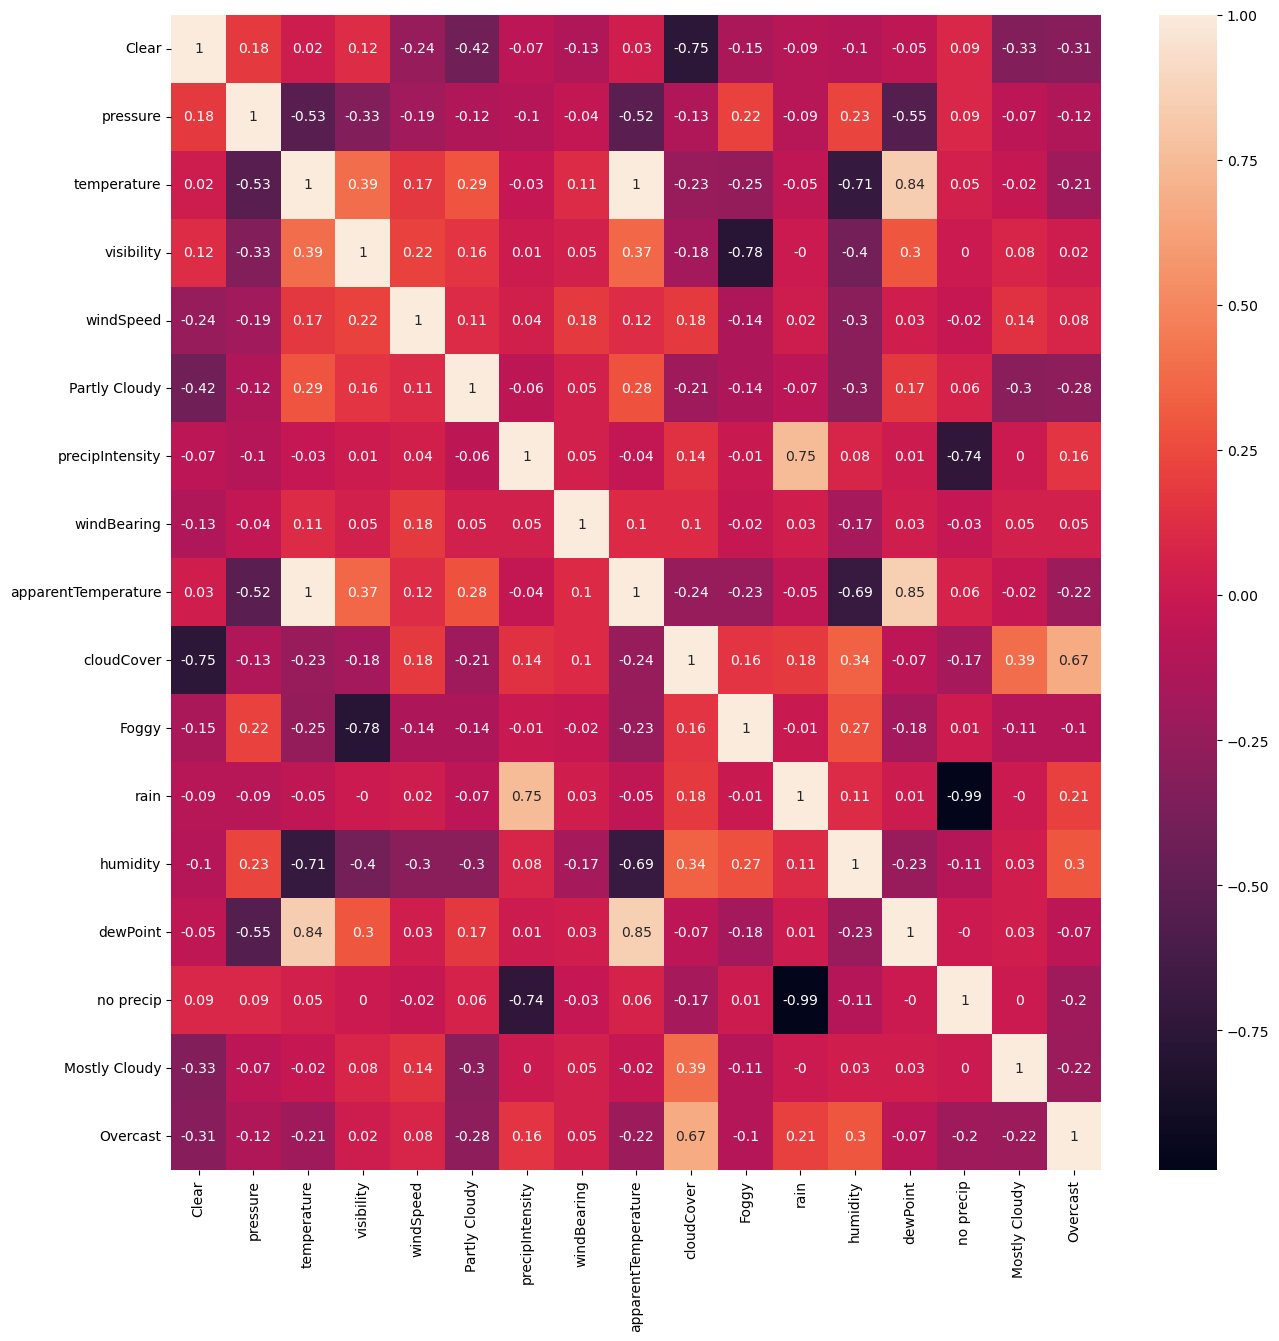

In [ ]:
regress_pressure = True
if regress_pressure:
    pres_df = df.loc[~df['pressure'].isna(), list(set(df.columns) - set(['PM10']))].copy()

    plt.figure(figsize=(15, 15))
    p_corr = pres_df.corr(numeric_only=False, method='pearson')
    p_corr=p_corr.round(decimals=2)
    sns.heatmap(p_corr, annot=True)

    # sns.pairplot(pres_df,hue='pressure')

    cat_columns = ['no precip', 'rain', 'Clear', 'Foggy', 'Mostly Cloudy', 'Overcast', 'Partly Cloudy']
    num_columns = list(set(pres_df.columns) - set(cat_columns + ['pressure']))

    # EXPERIMENT WITH ONLY >0.3 correlated features
    # cat_columns = []
    # num_columns = ['temperature', 'dewPoint', 'humidity', 'precipIntensity', 'visibility']
    # -- 
    X = pres_df.drop(columns=['pressure'])
    y = pres_df['pressure']
    # print(X.shape)
    # print(y.shape)
    # sns.histplot(y)
    bins = np.linspace(min(y), max(y), 15).astype(int)
    y_binned = np.digitize(y, bins)
    # print(pd.DataFrame({'y': y, 'y_binned': y_binned}).sort_values('y'))
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE).split(X, y_binned)

    col_trans = ColumnTransformer(
        [
            ('mms', MinMaxScaler(), num_columns),
            ('ore', OrdinalEncoder(), cat_columns)
        ],
        remainder='drop'
    )
    # scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
    pipeline = Pipeline([('col_trans', col_trans), ('reg', RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE))])
    sc = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1)
    print(sc)
    print(np.mean(sc)) # good result!
    pipeline.fit(X, y)


    pres_df_missing = df.loc[df['pressure'].isna(), list(set(df.columns) - set(['PM10']))].copy()
    X_pred = pres_df_missing.drop(columns=['pressure'])
    y_pred = pipeline.predict(X_pred)

    df.loc[df['pressure'].isna(), 'pressure'] = y_pred
else:
    df['pressure'].fillna(method='ffill', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7237 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PM10                 7237 non-null   float64
 1   apparentTemperature  7237 non-null   float64
 2   cloudCover           7237 non-null   float64
 3   dewPoint             7237 non-null   float64
 4   humidity             7237 non-null   float64
 5   precipIntensity      7237 non-null   float64
 6   pressure             7237 non-null   float64
 7   temperature          7237 non-null   float64
 8   visibility           7237 non-null   float64
 9   windBearing          7237 non-null   float64
 10  windSpeed            7237 non-null   float64
 11  no precip            7237 non-null   int64  
 12  rain                 7237 non-null   int64  
 13  Clear                7237 non-null   int64  
 14  Foggy                7237 non-null   int64  
 15  Mostly Cloudy        7237 non-null   i

In [ ]:
X = df.drop(columns=['PM10'])
y = df['PM10']

<AxesSubplot:>

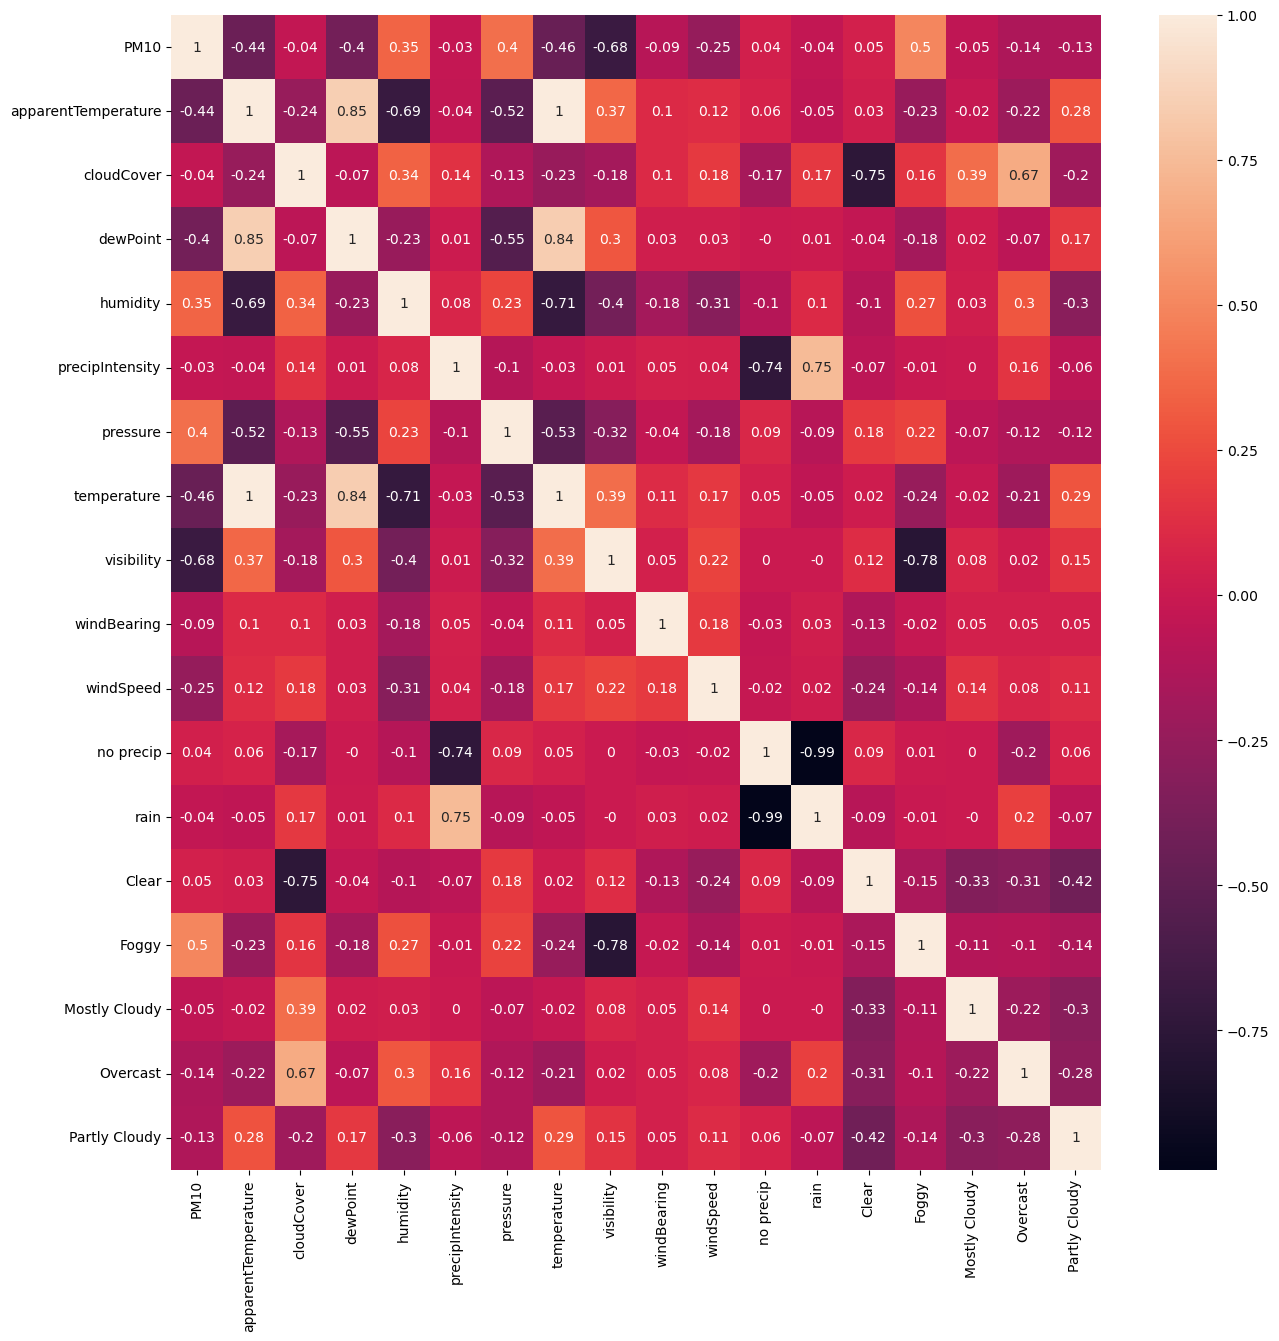

In [ ]:
# Corr heatmap
plt.figure(figsize=(15, 15))
p_corr = df.corr(numeric_only=False, method='pearson')
p_corr=p_corr.round(decimals=2)
sns.heatmap(p_corr, annot=True)

In [ ]:
# pairplot
 sns.pairplot(df)


In [ ]:
sns.pairplot(df,hue='PM10')

In [ ]:
def train_loop(X, y, reg, grid_dict):

    bins = np.linspace(min(y), max(y), 5).astype(int)
    y_binned = np.digitize(y, bins)
    print(reg)

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE).split(X, y_binned)
    cat_columns = ['no precip', 'rain', 'Clear', 'Foggy', 'Mostly Cloudy', 'Overcast', 'Partly Cloudy']
    num_columns = list(set(pres_df.columns) - set(cat_columns))

    col_trans = ColumnTransformer(
        [
            ('mms', MinMaxScaler(), num_columns),
            ('ore', OrdinalEncoder(), cat_columns)
        ],
        remainder='drop'
    )
    pipeline = Pipeline([('col_trans', col_trans), ('reg', reg)])

    # #create the GridSearch model and train it
    model = GridSearchCV(estimator = pipeline, 
                        param_grid = grid_dict,
                        cv = kf,
                        verbose = 5,
                        n_jobs = -1,
                        refit=False,
                        scoring='neg_median_absolute_error'
                        )
    model.fit(X, y)
    return model

In [ ]:
grid_dict = {'regrf__criterion': ['absolute_error', 'squared_error'],
param_dicts = [
            {
            'reg': RandomForestRegressor(),
            'name': "RF",
            'grid_dict': {'reg__criterion': ['absolute_error'],
                        #    'reg__max_depth': list(np.linspace(1, 30, 10, dtype = int)) + [None],
                           'reg__max_depth': [1, 5, 10],
                        #    'reg__max_features': [5, 10, None],
                        #    'reg__min_samples_leaf': [1, 5],
                        #    'reg__min_samples_split': [2, 5],
                           'reg__n_estimators': [10],
                        'reg__random_state': [RANDOM_STATE],
                        'reg__n_jobs': [-1]}
            },
            {
               'reg': Lasso(),
               'name': "Lasso",
               'grid_dict': {
                  'reg__alpha': [0.1, 1, 10]
               }

            },
              {
               'reg': ElasticNet(),
               'name': "ElasticNet",
               'grid_dict': {
                  'reg__alpha': [0.1, 1, 10]
               }

            },
              {
               'reg': Ridge(),
               'name': "Ridge",
               'grid_dict': {
                  'reg__alpha': [0.1, 1, 10]
               }

            },
              {
               'reg': KernelRidge(),
               'name': "KernelRidge",
               'grid_dict': {
                  'reg__alpha': [0.1, 1, 10],
                  'reg__kernel': ['rbf', 'poly']
               }

            },
              {
               'reg': LinearSVR(),
               'name': "LSVR",
               'grid_dict': {
                  'reg__C': [0.1, 1, 10],
                  'reg__epsilon': [0, 1]
               }

            },
              {
               'reg': SVR(),
               'name': "SVR",
               'grid_dict': {
                  'reg__C': [0.1, 1, 10],
                  'reg__epsilon': [0, 1],
                  'reg__kernel': ['rbf', 'poly'],
                  'reg__degree': [2,3,4]

               }

            },

]

best_models = []
best_model_names = []
for el in param_dicts:
      best_models.append(train_loop(X,y,el['reg'],el['grid_dict']))
      best_model_names.append(el['name'])

In [ ]:
#Homework 

    # grid_dict = {'regrf__criterion': ['absolute_error', 'squared_error'],
param_dicts = [
            {
            'reg': RandomForestRegressor(),
            'name': "RF",
            'grid_dict': {'reg__criterion': ['squared_error'],
                           'reg__max_depth': list(np.linspace(1, 50, 10, dtype = int)) + [None],
                           'reg__max_depth': [1, 20, 40],
                            'reg__max_features': [5, 10, None],
                            'reg__min_samples_leaf': [1, 5],
                            'reg__min_samples_split': [2, 5],
                           'reg__n_estimators': [50],
                        'reg__random_state': [RANDOM_STATE],
                        'reg__n_jobs': [-1]}
            },
            {
               'reg': Lasso(),
               'name': "Lasso",
               'grid_dict': {
                  'reg__alpha': [0.1, 1, 10]
               }

            },
              {
               'reg': ElasticNet(),
               'name': "ElasticNet",
               'grid_dict': {
                  'reg__alpha': [0.1, 1, 10]
               }

            },
              {
               'reg': Ridge(),
               'name': "Ridge",
               'grid_dict': {
                  'reg__alpha': [0.1, 1, 10]
               }

            },
              {
               'reg': KernelRidge(),
               'name': "KernelRidge",
               'grid_dict': {
                  'reg__alpha': [0.05, 1, 1.5],
                  'reg__kernel': ['rbf', 'poly']
               }

            },
              {
               'reg': LinearSVR(),
               'name': "LSVR",
               'grid_dict': {
                  'reg__C': [0.05, 1, 1.5],
                  'reg__epsilon': [0,0.5, 1]
               }

            },
              {
               'reg': SVR(),
               'name': "SVR",
               'grid_dict': {
                  'reg__C': [0.05, 1, 1.5],
                  'reg__epsilon': [0, 1],
                  'reg__kernel': ['rbf', 'poly'],
                  'reg__degree': [2,4,6]

               }

            },

]

best_models = []
best_model_names = []
for el in param_dicts:
      best_models.append(train_loop(X,y,el['reg'],el['grid_dict']))
      best_model_names.append(el['name'])

RandomForestRegressor()
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Lasso()
Fitting 3 folds for each of 3 candidates, totalling 9 fits
ElasticNet()
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Ridge()
Fitting 3 folds for each of 3 candidates, totalling 9 fits
KernelRidge()
Fitting 3 folds for each of 6 candidates, totalling 18 fits
LinearSVR()
Fitting 3 folds for each of 9 candidates, totalling 27 fits
SVR()
Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [ ]:
for el, name in zip(best_models, best_model_names):
    print(name)
    print(el.best_score_)
    print(el.best_params_)


RF
-12.421200000166671
{'reg__criterion': 'squared_error', 'reg__max_depth': 40, 'reg__max_features': 10, 'reg__min_samples_leaf': 1, 'reg__min_samples_split': 2, 'reg__n_estimators': 50, 'reg__n_jobs': -1, 'reg__random_state': 42}
Lasso
-22.261021167348048
{'reg__alpha': 0.1}
ElasticNet
-25.639140368018534
{'reg__alpha': 0.1}
Ridge
-22.272548035072678
{'reg__alpha': 1}
KernelRidge
-18.870401540715324
{'reg__alpha': 0.05, 'reg__kernel': 'poly'}
LSVR
-16.519203196116283
{'reg__C': 0.05, 'reg__epsilon': 1}
SVR
-14.668330254525708
{'reg__C': 1.5, 'reg__degree': 6, 'reg__epsilon': 1, 'reg__kernel': 'poly'}
